<a href="https://colab.research.google.com/github/PV-J/hetero-memory-lab/blob/main/examples/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 (Markdown):

# hetero-memory-lab 🏗️ Interactive Roofline Model

**Hands-on GPU performance modeling:** bandwidth vs compute vs tiling vs cache.

[![Roofline](https://github.com/PV-J/hetero-memory-lab/raw/main/roofline_chart.png)](https://github.com/PV-J/hetero-memory-lab)

Cell 2 (Code): Install + Setup

In [3]:
# Clone repo + install
!git clone https://github.com/PV-J/hetero-memory-lab.git
%cd hetero-memory-lab
!pip install -r requirements.txt

import sys
sys.path.append('.')
print('✅ hetero-memory-lab ready!')


Cloning into 'hetero-memory-lab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 75 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 177.65 KiB | 5.73 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/hetero-memory-lab/hetero-memory-lab/hetero-memory-lab
✅ hetero-memory-lab ready!


Cell 3 (Code): Part 1 - Bandwidth

In [4]:
from memory_lab.system_model import SystemModel
from memory_lab.compute_core import ComputeCore
from memory_lab.memory_model import MemoryModel

# Low vs High bandwidth
problem_size = 10*1024*1024  # 10MB
compute = ComputeCore(peak_flops=1e12)

mem_low = MemoryModel(bandwidth_gbps=1.0, access_pattern="sequential")
mem_high = MemoryModel(bandwidth_gbps=1000.0, access_pattern="sequential")

sys_low = SystemModel(problem_size_bytes=problem_size, compute_core=compute, memory_model=mem_low)
sys_high = SystemModel(problem_size_bytes=problem_size, compute_core=compute, memory_model=mem_high)

r_low = sys_low.run()
r_high = sys_high.run()

print(f'Low BW (1 Gbit/s): {r_low["regime"]} ({r_low["memory_time_s"]:.1e}s mem)')
print(f'High BW (1 Tbit/s): {r_high["regime"]} ({r_high["memory_time_s"]:.1e}s mem)')


Low BW (1 Gbit/s): memory-bound (8.4e-02s mem)
High BW (1 Tbit/s): memory-bound (8.4e-05s mem)


Cell 4 (Code): Part 2 - Sequential vs Random

In [5]:
# Sequential vs Random (same bandwidth!)
mem_seq = MemoryModel(bandwidth_gbps=1000.0, access_pattern="sequential")
mem_rand = MemoryModel(bandwidth_gbps=1000.0, access_pattern="random")

sys_seq = SystemModel(problem_size_bytes=problem_size, compute_core=compute, memory_model=mem_seq)
sys_rand = SystemModel(problem_size_bytes=problem_size, compute_core=compute, memory_model=mem_rand)

r_seq = sys_seq.run()
r_rand = sys_rand.run()

print(f'Sequential: {r_seq["memory_time_s"]:.1e}s')
print(f'Random:    {r_rand["memory_time_s"]:.1e}s')
print(f'Penalty:   {r_rand["memory_time_s"]/r_seq["memory_time_s"]:.1f}x slower! 🔥')


Sequential: 8.4e-05s
Random:    3.4e-04s
Penalty:   4.0x slower! 🔥


Part 3 - Tiling

In [6]:
# Tiling: 2 → 16 ops/byte
naive = SystemModel(problem_size_bytes=problem_size,
                   compute_core=ComputeCore(peak_flops=1e12, ops_per_byte=2.0),
                   memory_model=mem_seq)
tiled = SystemModel(problem_size_bytes=problem_size,
                   compute_core=ComputeCore(peak_flops=1e12, ops_per_byte=16.0),
                   memory_model=mem_seq)

print('Naive (2 ops/byte):', naive.run()['regime'])
print('Tiled (16 ops/byte):', tiled.run()['regime'])


Naive (2 ops/byte): memory-bound
Tiled (16 ops/byte): compute-bound


Roofline Chart

Generating roofline data...

=== Roofline Summary Table ===
Pattern      BW (GB/s)  Ops/byte Achieved TFLOP/s Regime    
------------------------------------------------------------
sequential   12         0.1      0.00         memory-bound
sequential   12         0.5      0.01         memory-bound
sequential   12         1.0      0.01         memory-bound
sequential   12         2.0      0.02         memory-bound
sequential   12         4.0      0.05         memory-bound
sequential   12         8.0      0.10         memory-bound
sequential   12         16.0     0.20         memory-bound
sequential   12         32.0     0.40         memory-bound
sequential   12         64.0     0.80         memory-bound
sequential   62         0.1      0.01         memory-bound
sequential   62         0.5      0.03         memory-bound
sequential   62         1.0      0.06         memory-bound
✓ Saved 54 points to roofline_data.csv

✅ Step 3 complete! Use roofline_data.csv with any plotting tool.
Real 

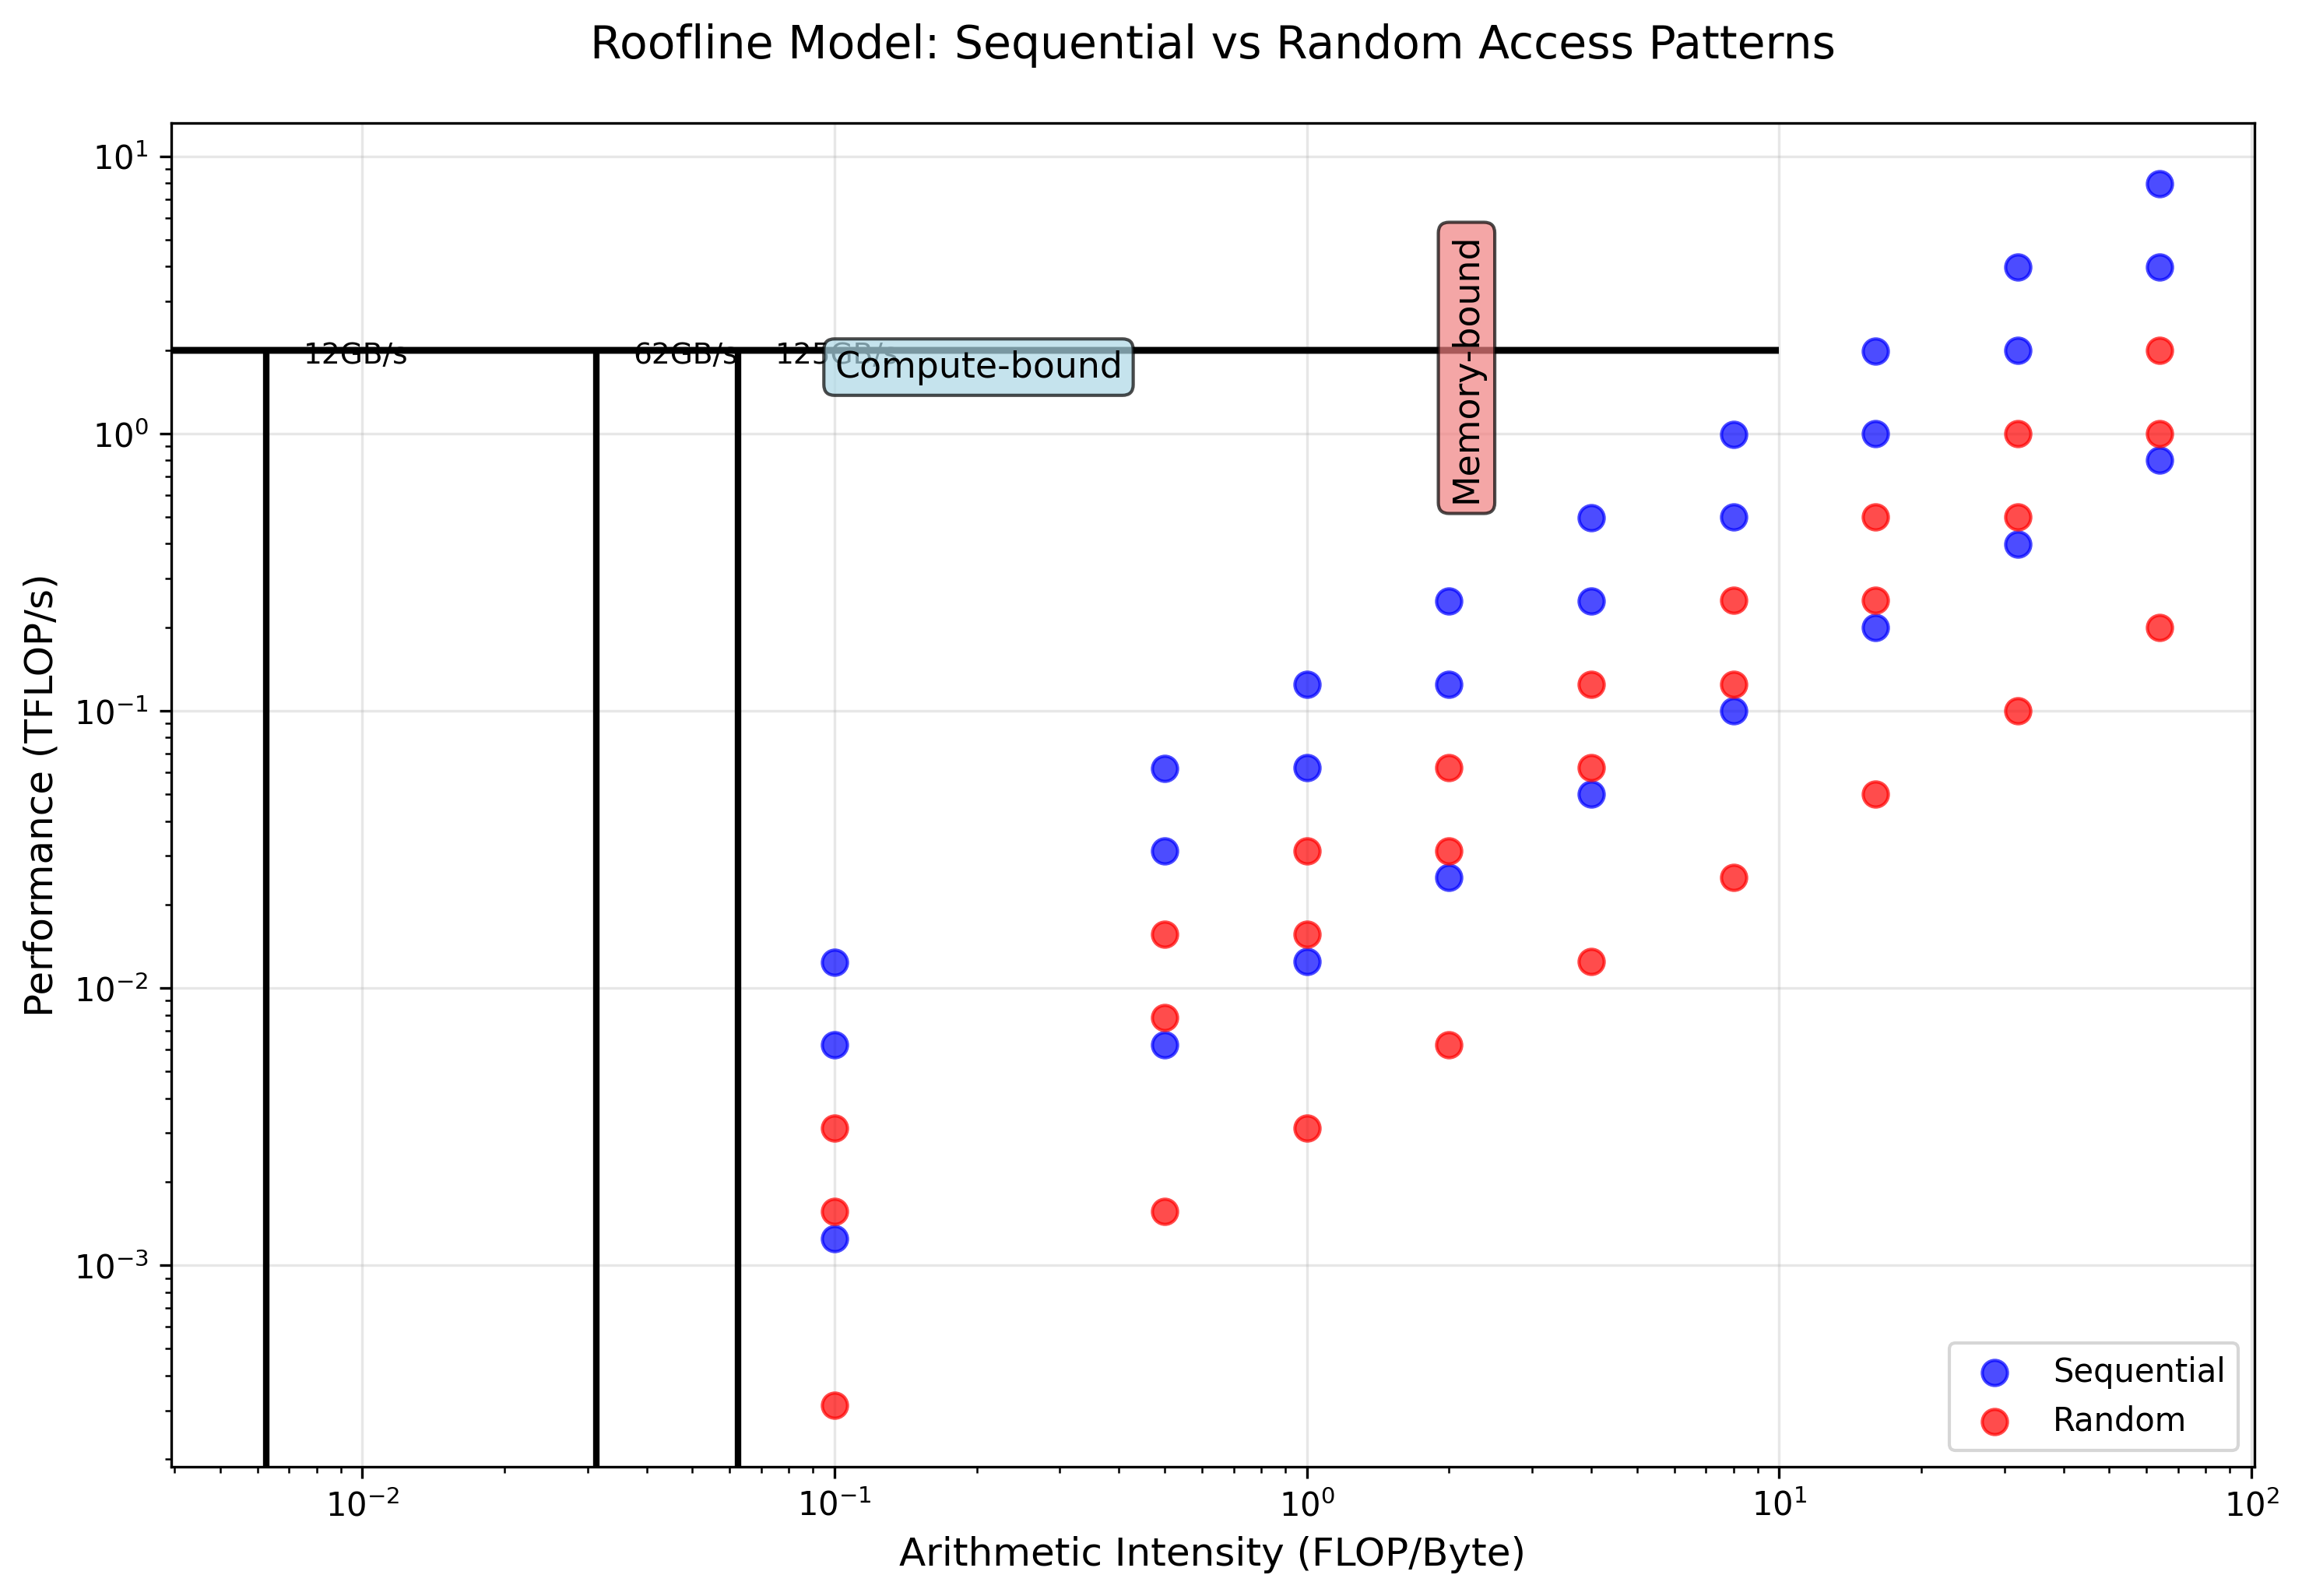

In [7]:
# Generate + show roofline!
!python examples/example_roofline_sweep.py
!python plot_roofline.py

from IPython.display import Image
Image('roofline_chart.png', width=800)
